Directories

In [1]:
import os

BASE_DIR = os.getcwd()
MAPS_DIR = os.path.join(BASE_DIR, "..", "mappings")

Imports

In [2]:
from eda import EDA
from region_eda import RegionEDA
from etl import ETLPipeline
from feature_eng import FeatureEngineer
from xgb import XGBoost

ETL Pipeline

In [3]:
etl = ETLPipeline()

etl.extract("ruchi798/data-science-job-salaries", "ds_salaries.csv")
etl.extract("sazidthe1/data-science-salaries", "data_science_salaries.csv")
etl.extract("arnabchaki/data-science-salaries-2025", "salaries.csv")

etl.transform(
    columns_map=os.path.join(MAPS_DIR, "columns.json"),
    values_map=os.path.join(MAPS_DIR, "values.json"),
)

dataset = etl.load()

Std. custom: 100%|██████████| 3/3 [00:00<00:00, 44.01it/s]


EDA

Missing values or NaNs: 0
Data dimensions (w x h): 52,938 x 11

                    unique_values
salary_in_usd               10537
salary                       9484
job_title                     363
employee_residence             98
company_location               92
salary_currency                27
work_year                       6
experience_level                4
employment_type                 4
work_model                      3
company_size                    3

                    mean        std     min      25%       50%       75%  \
work_year        2024.20       0.76  2020.0   2024.0    2024.0    2025.0   
salary         161954.80  300361.98  4000.0  96600.0  140000.0  193000.0   
salary_in_usd  151657.66   77900.82  2859.0  96500.0  139587.0  191000.0   

                      max  
work_year          2025.0  
salary         30400000.0  
salary_in_usd    800000.0  

                   unique             top   freq
experience_level        4          Senior  27989
employment_

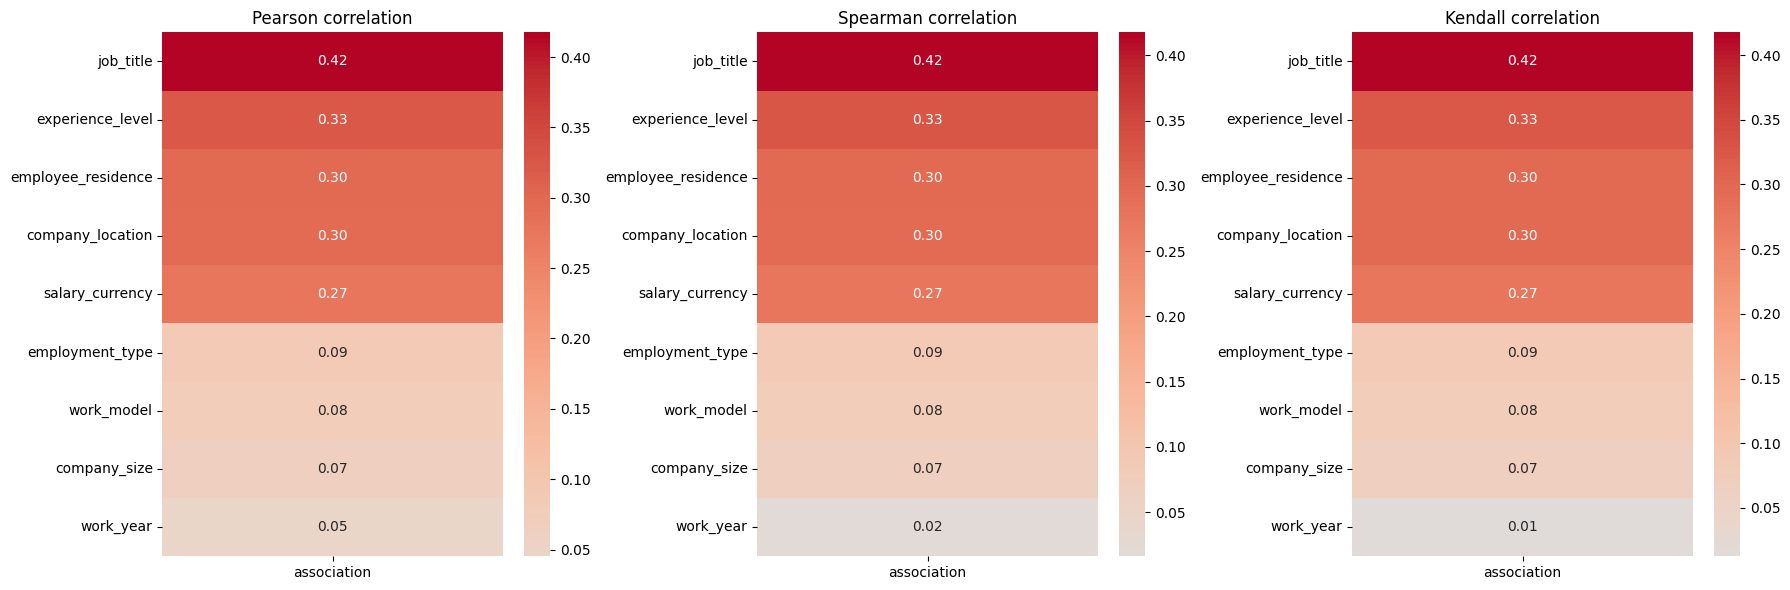

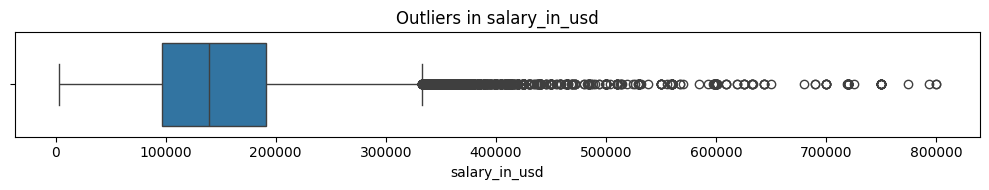

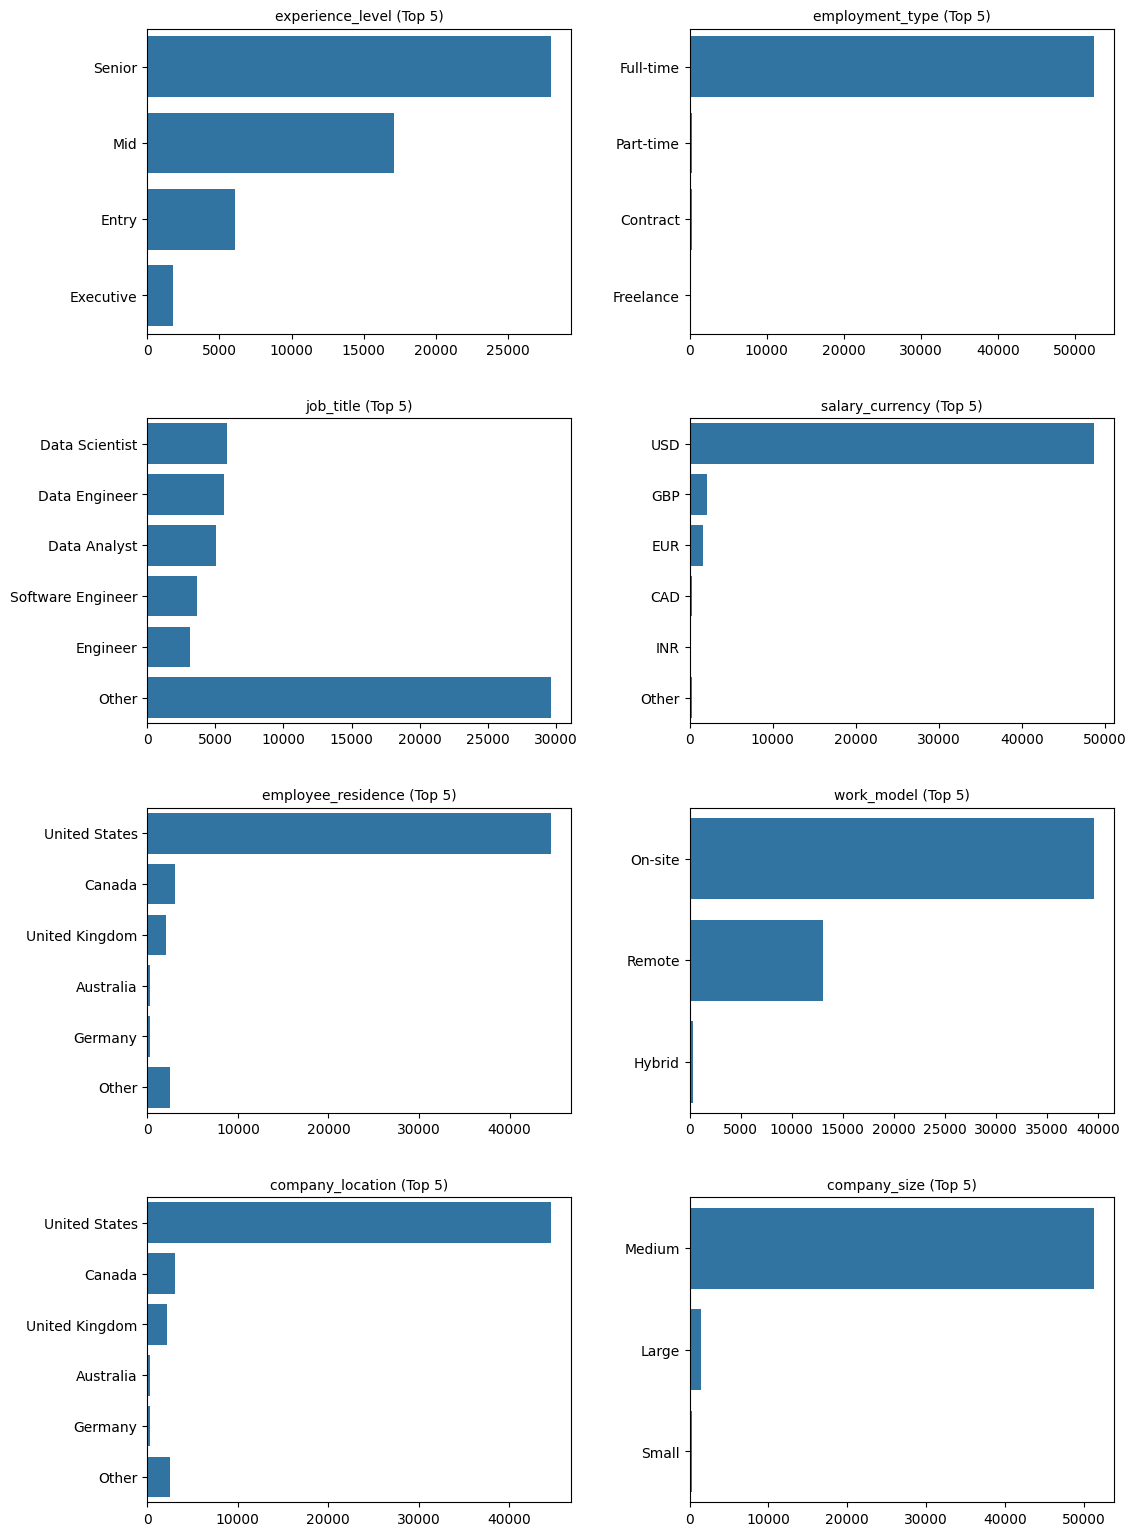

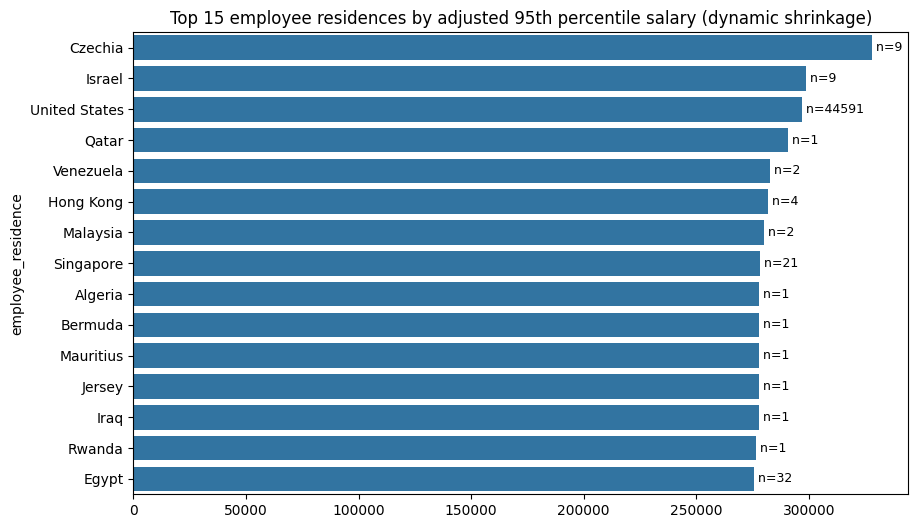

In [4]:
eda = EDA(dataset)
eda.describe()
eda.correlations(target="salary_in_usd", exclude_cols=["salary"])
eda.outliers(exclude_cols=["work_year", "salary"], top_n=5)
eda.geography_salary()

Feature engineering

In [5]:
eng = FeatureEngineer(dataset)
eng.cleanup()
eng.prepare()
eng.cluster_careers(os.path.join(MAPS_DIR, "topics.json"))
eng.print_examples(n = 10)

dataset = eng.dataset

Device set to use cuda:0
Merging synonyms of titles: 100%|██████████| 351/351 [00:00<00:00, 3410.60it/s]

[cache] Loaded from cache/careers_53a5fc98d81b8ae9ff994437590842ac.parquet
Data Engineer                  | p_ai=0.05, p_data=0.95, p_software=0.32, p_academic=0.00
Software Engineer              | p_ai=0.00, p_data=0.37, p_software=0.83, p_academic=0.00
Engineer                       | p_ai=0.68, p_data=0.78, p_software=0.29, p_academic=0.00
Data Architect                 | p_ai=0.00, p_data=0.56, p_software=0.12, p_academic=0.00
Engineer                       | p_ai=0.68, p_data=0.78, p_software=0.29, p_academic=0.00
Developer                      | p_ai=0.00, p_data=0.91, p_software=0.82, p_academic=0.08
AI Engineer                    | p_ai=0.85, p_data=0.71, p_software=0.12, p_academic=0.05
Analytics Specialist           | p_ai=0.01, p_data=0.92, p_software=0.00, p_academic=0.02
Data Analyst                   | p_ai=0.01, p_data=0.95, p_software=0.00, p_academic=0.00
Data Architect                 | p_ai=0.00, p_data=0.56, p_software=0.12, p_academic=0.00


Podział na 2 zbiory

In [6]:
# ile próbek ma każdy kraj
counts = dataset["employee_residence"].value_counts()

# kraje z min 100 obserwacjami
valid_countries = counts[counts >= 200].index
filtered = dataset[dataset["employee_residence"].isin(valid_countries)].copy()

# przypisz etykiety regionów
filtered["region_group"] = filtered["employee_residence"].apply(
    lambda c: "US+CA+UK" if c in {"United States", "Canada", "United Kingdom"} else "Rest"
)

# podział na regiony P95
def trim_region(df, col="salary_in_usd", q=0.95):
    cutoff = df[col].quantile(q)
    return df[df[col] <= cutoff].copy()

us_ca_uk = trim_region(filtered[filtered["region_group"] == "US+CA+UK"])
rest     = trim_region(filtered[filtered["region_group"] == "Rest"])

Region-based EDA

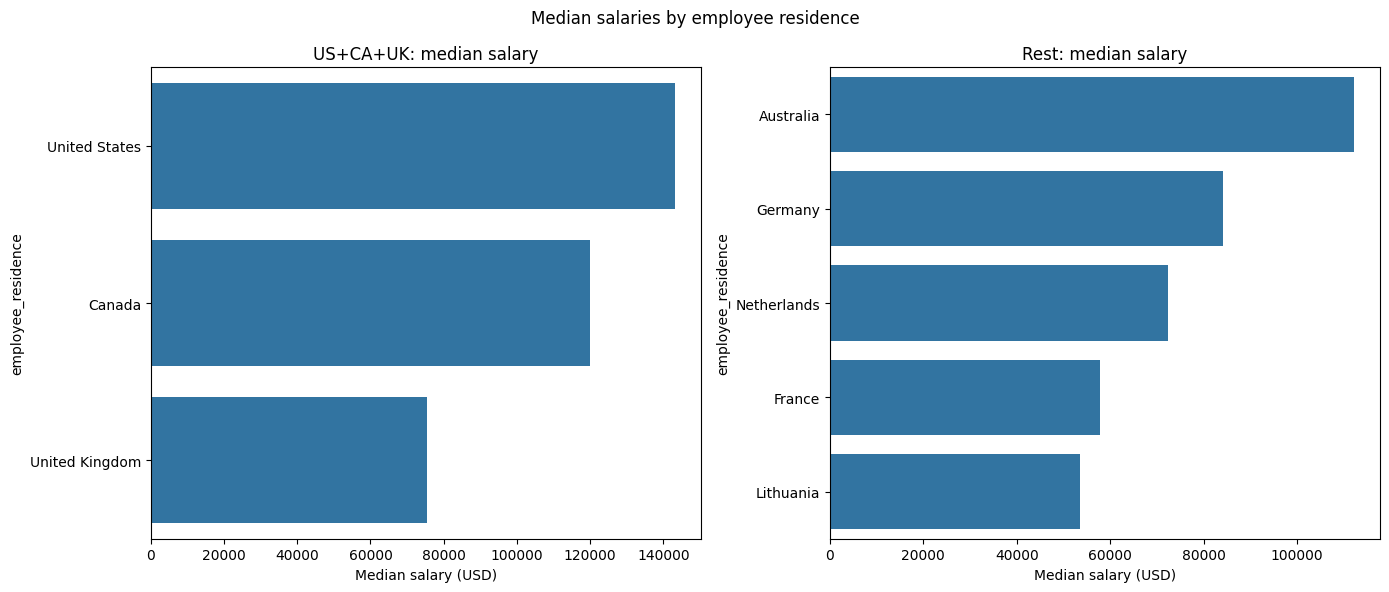

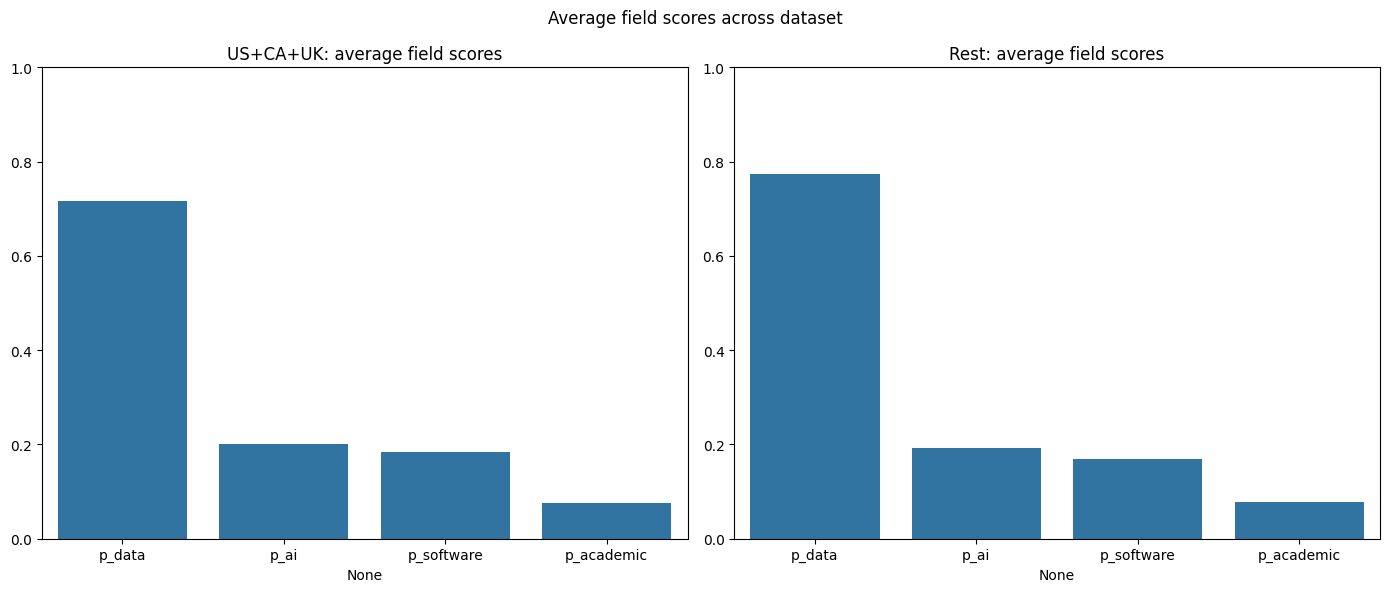

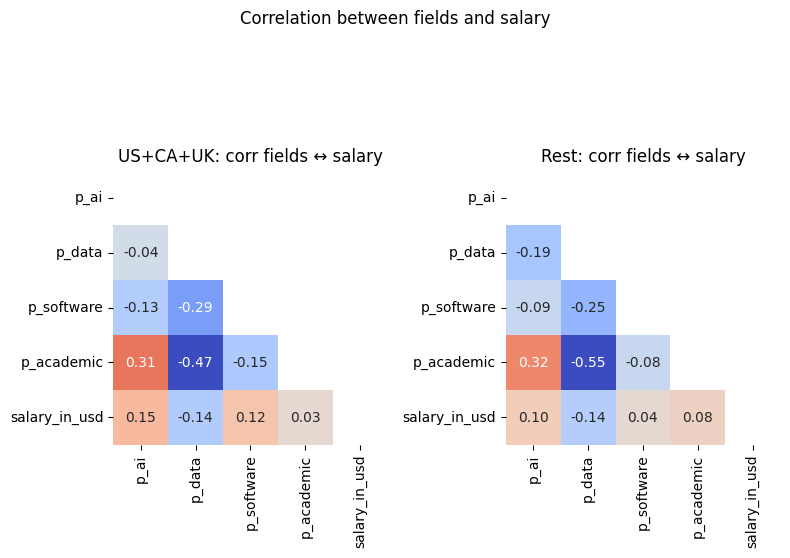

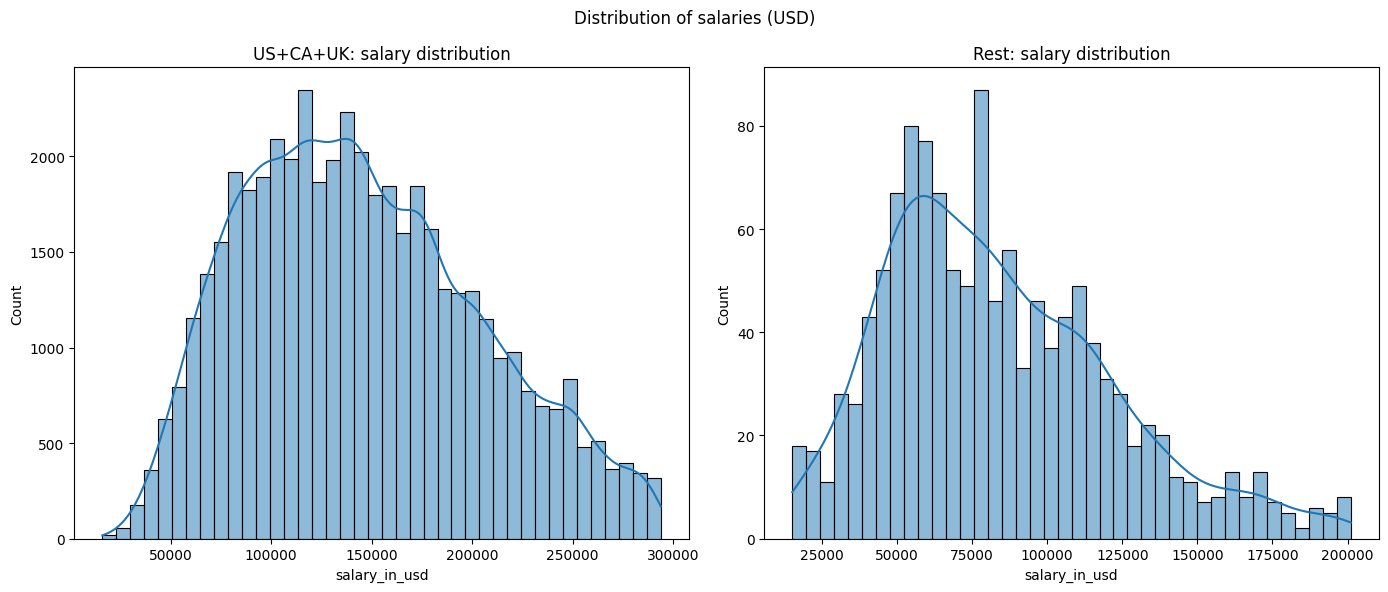

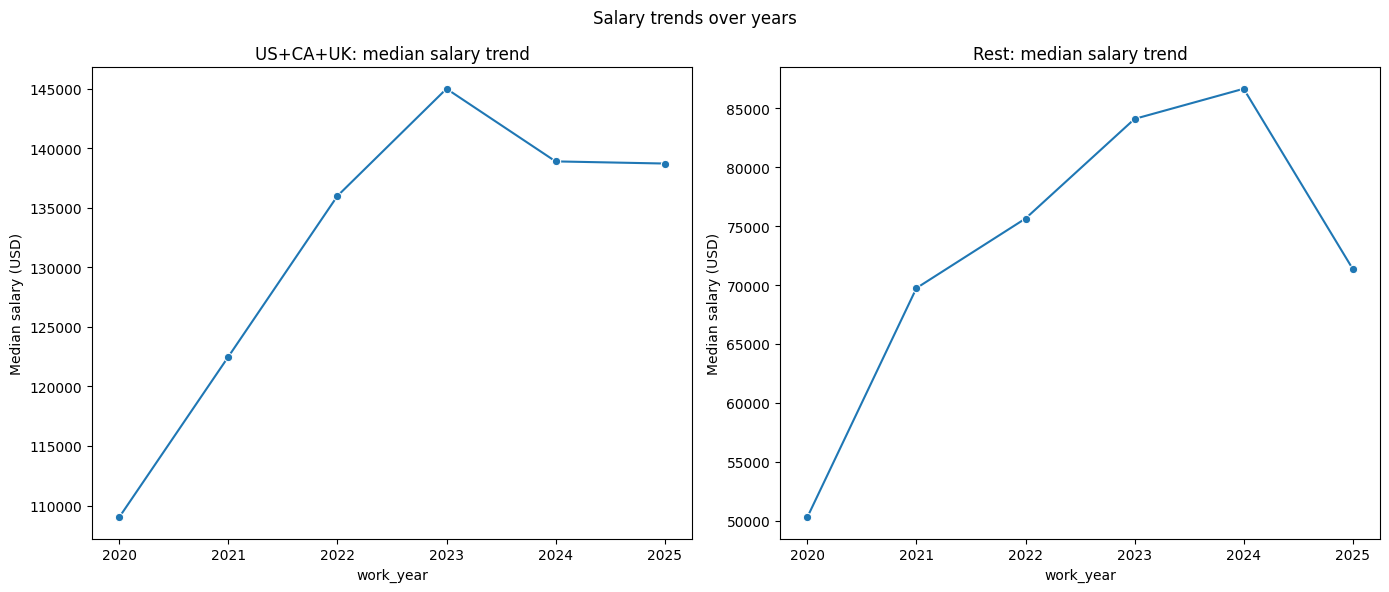

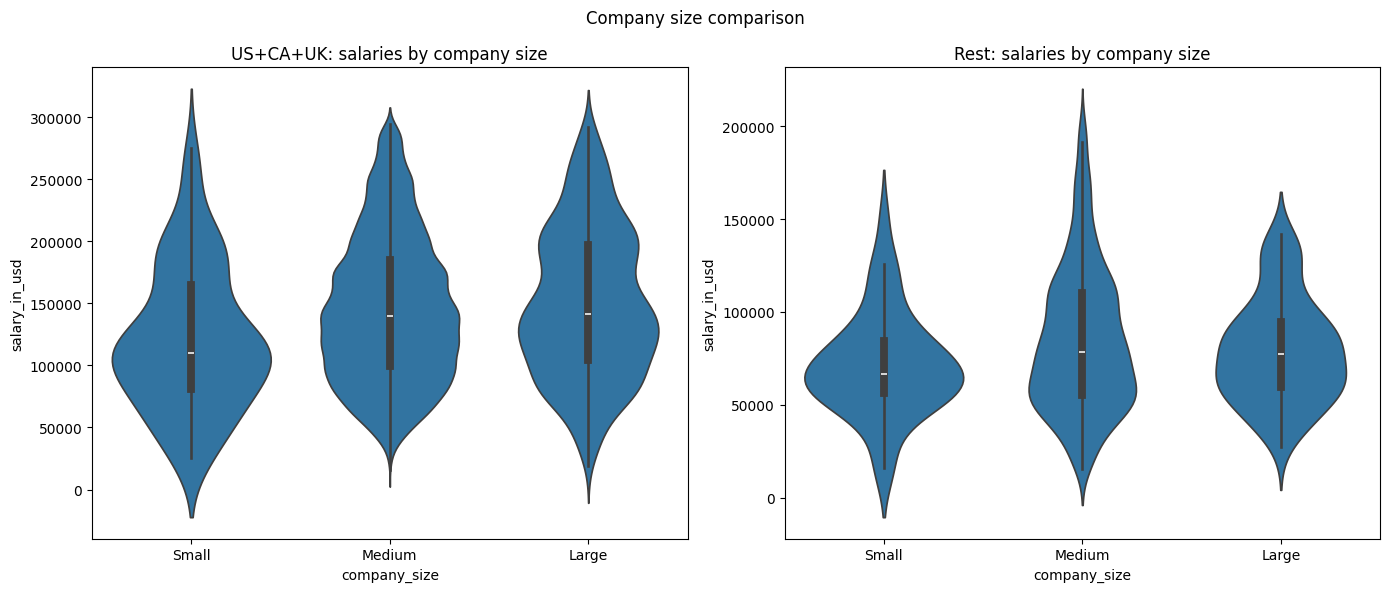

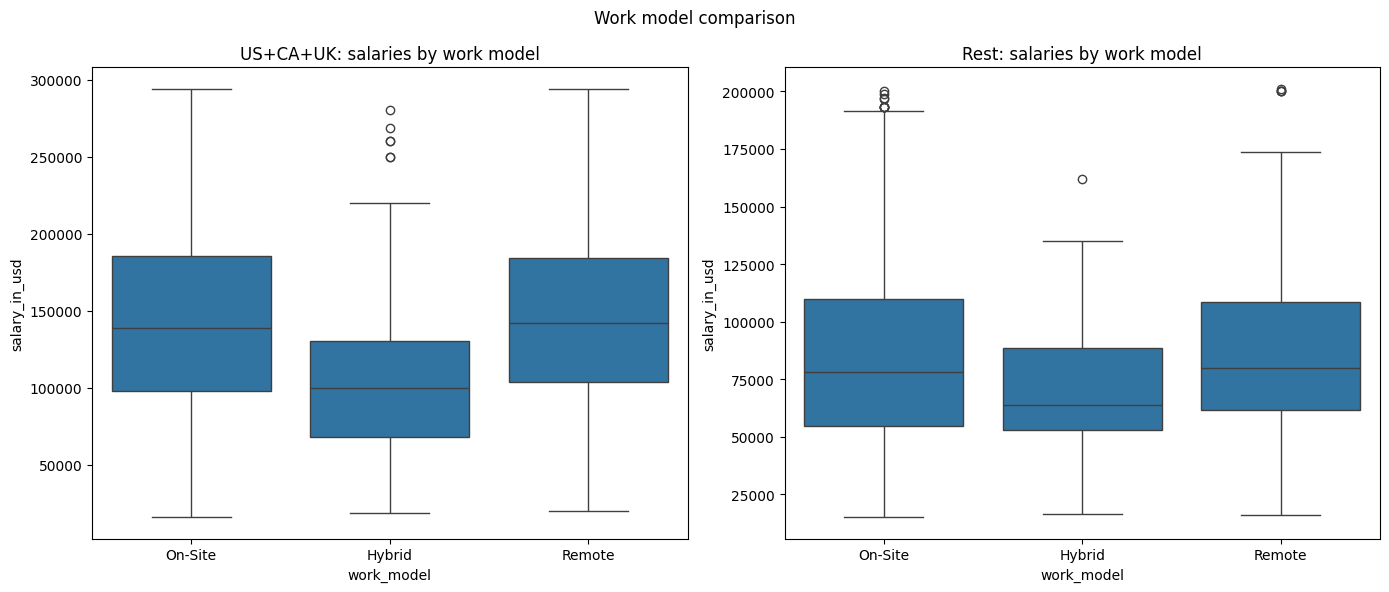

In [7]:
report_eda = RegionEDA(us_ca_uk, rest, os.path.join(MAPS_DIR, "orders.json"))

report_eda.geography_salary()
report_eda.field_profiles()
report_eda.salary_distributions()
report_eda.salary_trends()
report_eda.salary_vs_company_size()
report_eda.salary_vs_work_model()

XGBoost

In [8]:
xgb_us_ca_uk = XGBoost(us_ca_uk)

xgb_us_ca_uk.tune(1)
xgb_us_ca_uk.fit()

[I 2025-09-26 16:44:25,276] A new study created in memory with name: no-name-ae696dd1-728b-4413-9565-f1606673b81b


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-09-26 16:44:26,805] Trial 0 finished with value: 51700.493769402245 and parameters: {'n_estimators': 953, 'learning_rate': 0.0008521079151563663, 'max_depth': 6}. Best is trial 0 with value: 51700.493769402245.
✅ Best trial: {'n_estimators': 953, 'learning_rate': 0.0008521079151563663, 'max_depth': 6}
📊 Evaluation on validation set:
RMSE: 51700.4938
MAE: 42502.7070
R2: 0.2312


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,True
,eval_metric,None


In [9]:
xgb_rest = XGBoost(rest)

xgb_rest.tune(1)
xgb_rest.fit()

[I 2025-09-26 16:44:28,347] A new study created in memory with name: no-name-80824b76-8d23-416d-980b-3c3c9af932ed


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-09-26 16:44:28,686] Trial 0 finished with value: 40890.23120502011 and parameters: {'n_estimators': 310, 'learning_rate': 5.4729245850154386e-05, 'max_depth': 13}. Best is trial 0 with value: 40890.23120502011.
✅ Best trial: {'n_estimators': 310, 'learning_rate': 5.4729245850154386e-05, 'max_depth': 13}
📊 Evaluation on validation set:
RMSE: 40890.2312
MAE: 31401.2129
R2: 0.0056


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,True
,eval_metric,None


SHAP

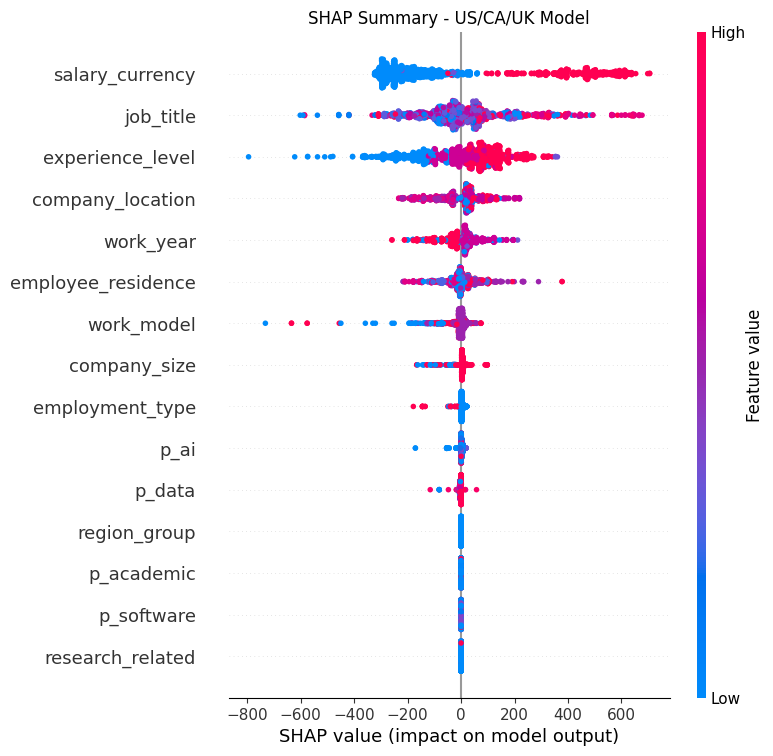

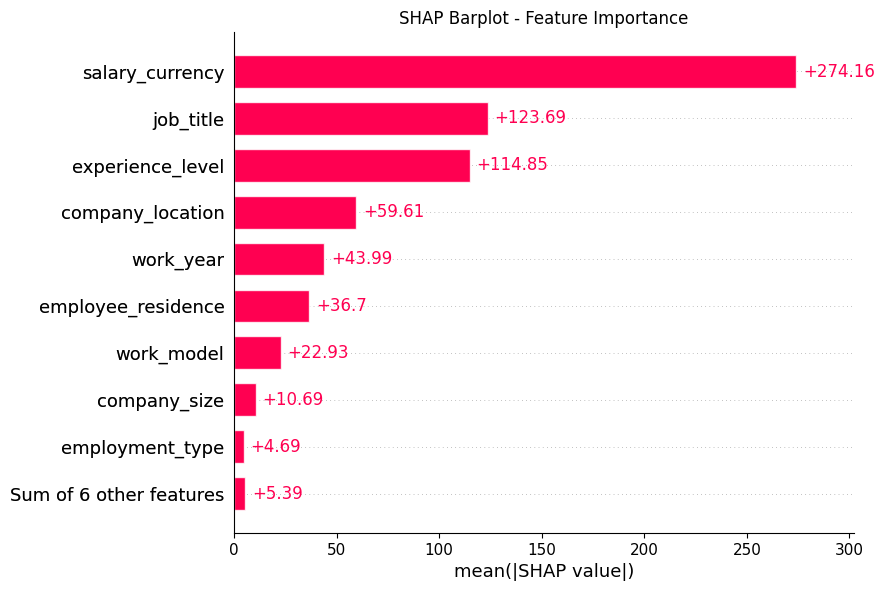

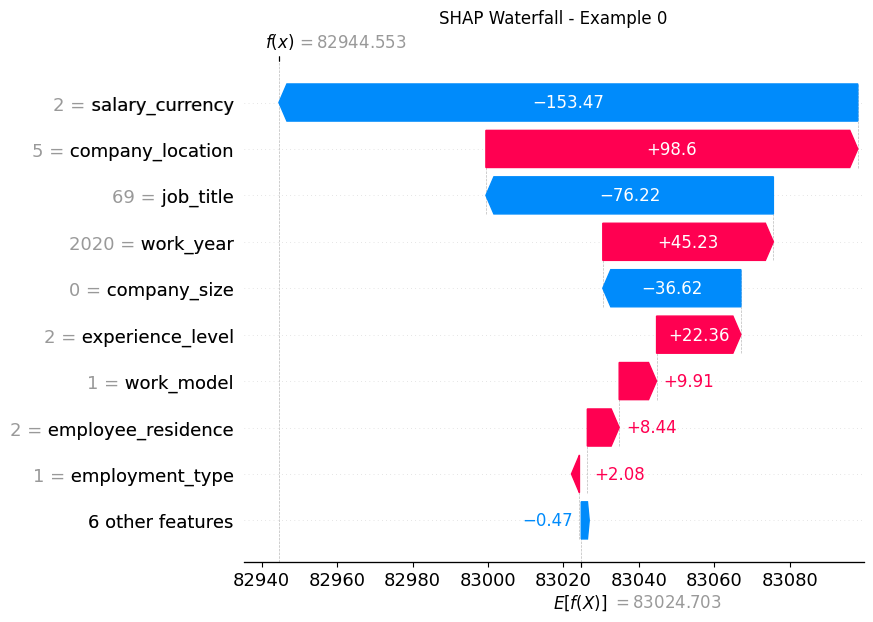

In [10]:
import matplotlib.pyplot as plt
import shap

# zrób wersję danych numerycznych tylko do SHAP
X_numeric = xgb_rest.X.copy()
for col in X_numeric.select_dtypes(include="category"):
    X_numeric[col] = X_numeric[col].cat.codes

# TreeExplainer dla XGBoost
explainer = shap.TreeExplainer(xgb_rest.model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_numeric)

# summary plot z tytułem
shap.summary_plot(shap_values, X_numeric, show=False)
plt.title("SHAP Summary - US/CA/UK Model")
plt.show()

# bar plot z tytułem
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Barplot - Feature Importance")
plt.show()

# waterfall dla jednej obserwacji
shap.plots.waterfall(shap_values[0], show=False)
plt.title("SHAP Waterfall - Example 0")
plt.show()
